#**Arifa Kokab - Final Project AAI-521**

In [1]:
from google.colab import files
files.upload()  # Upload your kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arifakokab6939","key":"1605554cf0e8a918ca2d83985c976e6d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/sad/Training_65242339.jpg  
  inflating: /content/dataset/train/sad/Training_65267116.jpg  
  inflating: /content/dataset/train/sad/Training_65275626.jpg  
  inflating: /content/dataset/train/sad/Training_6529266.jpg  
  inflating: /content/dataset/train/sad/Training_65329617.jpg  
  inflating: /content/dataset/train/sad/Training_65338712.jpg  
  inflating: /content/dataset/train/sad/Training_65338797.jpg  
  inflating: /content/dataset/train/sad/Training_65387162.jpg  
  inflating: /content/dataset/train/sad/Training_65404494.jpg  
  inflating: /content/dataset/train/sad/Training_65426218.jpg  
  inflating: /content/dataset/train/sad/Training_65430136.jpg  
  inflating: /content/dataset/train/sad/Training_65437377.jpg  
  inflating: /content/dataset/train/sad/Training_6545735.jpg  
  inflating: /content/dataset/train/sad/Training_65463385.jpg  
  inflating: /content/dataset/train/sad/Training_654739

In [4]:
!ls /content/dataset

test  train


In [5]:
!ls /content/dataset/train
!ls /content/dataset/test

angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight

In [7]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 30
LEARNING_RATE = 1e-5

# Paths to training and test data
train_path = "/content/dataset/train"
test_path = "/content/dataset/test"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
# Load Pretrained MobileNetV2 and fine-tune
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Unfreeze all layers for fine-tuning
base_model.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

# Define callbacks
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [
    lr_callback,
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

Class Weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [12]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 384s 372ms/step - accuracy: 0.1483 - loss: 2.5189 - val_accuracy: 0.1711 - val_loss: 1.9698 - learning_rate: 1.0000e-05
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 305s 336ms/step - accuracy: 0.1612 - loss: 2.0322 - val_accuracy: 0.1636 - val_loss: 1.9399 - learning_rate: 1.0000e-05
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 305s 338ms/step - accuracy: 0.1686 - loss: 1.9727 - val_accuracy: 0.1956 - val_loss: 1.9175 - learning_rate: 1.0000e-05
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 313s 346ms/step - accuracy: 0.1895 - loss: 1.9140 - val_accuracy: 0.2211 - val_loss: 1.8777 - learning_rate: 1.0000e-05
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 312s 345ms/step - accuracy: 0.2169 - loss: 1.8564 - val_accuracy: 0.2458 - val_loss: 1.8336 - learning_rate: 1.0000e-05
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 302s 334ms/step - accuracy: 0.2300 - loss: 1.8306 - val_accuracy: 0.2910 - val_loss: 1.7831 - learning_rate: 1.0000e-05
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 305s 336ms/

In [13]:
# Save the final model
model.save("mobilenetv2_fine_tuned_final.keras")

In [14]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4030 - loss: 1.4141
Test Loss: 1.3085689544677734
Test Accuracy: 0.5054332613945007


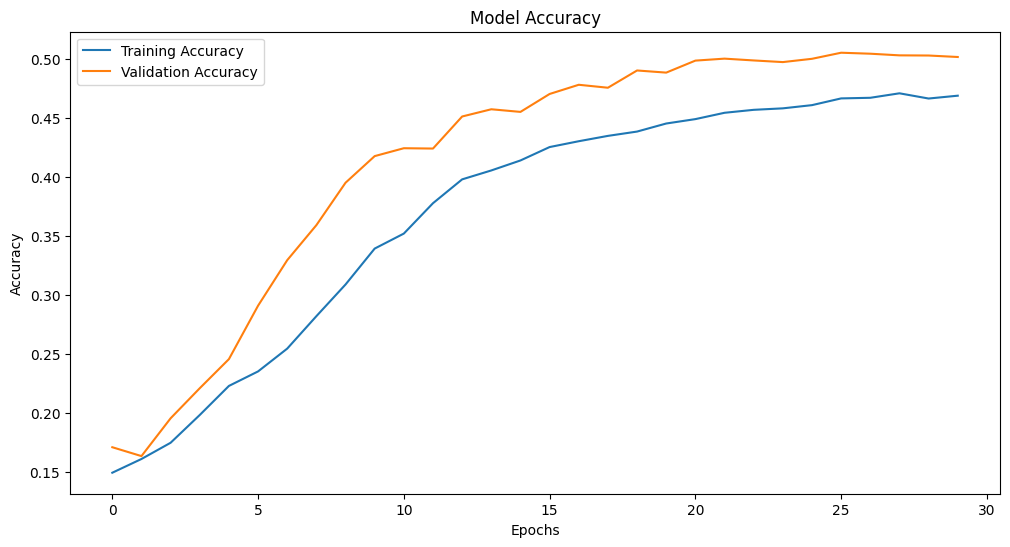

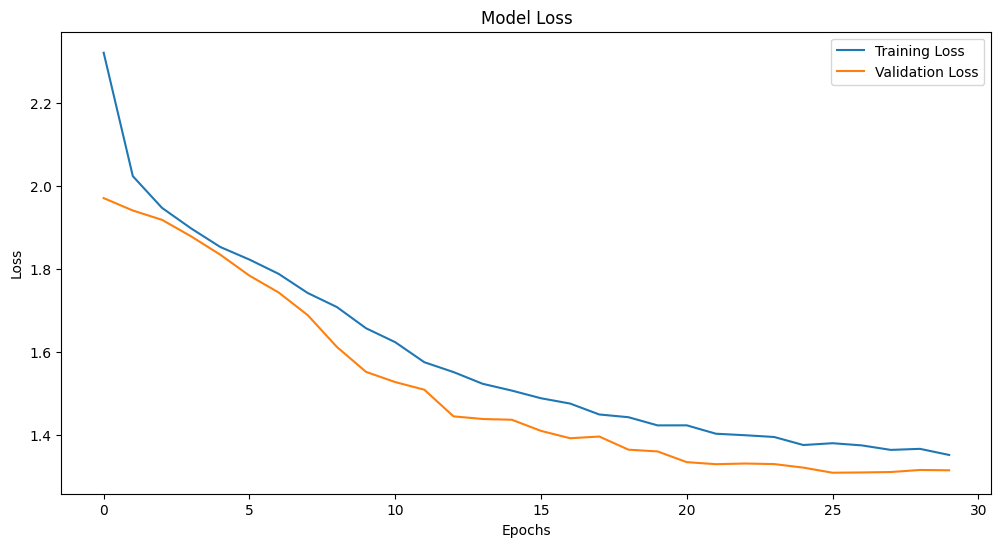

In [15]:
# Visualize Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

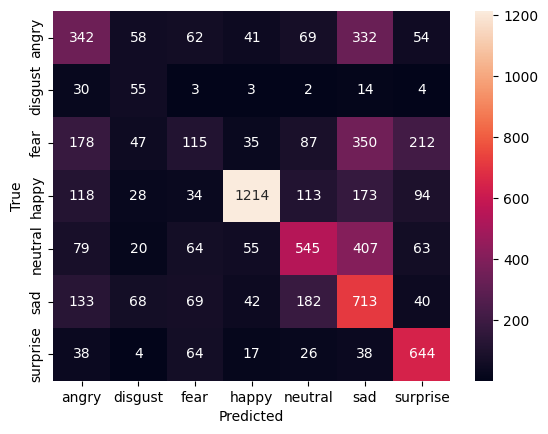

In [18]:
#Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
#Delve deeper into model performance

# Generate predictions on the test set
y_pred = np.argmax(model.predict(test_generator), axis=1)  # Predicted class indices
y_true = test_generator.classes  # True class labels

# Map class indices to emotion labels
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("Classification Report:")
print(report)

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step
Classification Report:
              precision    recall  f1-score   support

       angry     0.3725    0.3570    0.3646       958
     disgust     0.1964    0.4955    0.2813       111
        fear     0.2798    0.1123    0.1603      1024
       happy     0.8628    0.6843    0.7633      1774
     neutral     0.5322    0.4420    0.4829      1233
         sad     0.3518    0.5718    0.4356      1247
    surprise     0.5797    0.7750    0.6632       831

    accuracy                         0.5054      7178
   macro avg     0.4536    0.4911    0.4502      7178
weighted avg     0.5256    0.5054    0.4999      7178

Confusion Matrix:
[[ 342   58   62   41   69  332   54]
 [  30   55    3    3    2   14    4]
 [ 178   47  115   35   87  350  212]
 [ 118   28   34 1214  113  173   94]
 [  79   20   64   55  545  407   63]
 [ 133   68   69   42  182  713   40]
 [  38    4   64   17   26   38  644]]
